# Example 2B: Forward Stepwise Selection 

Forward Stepwise Selection (FSS) is less computationally complex than BSS because it does not consider every possibility. Instead, it looks to construct a model by adding one variable at a time. In the first iteration, it will consider which of the variables is most productive to add. Once it adds that variable, it will repeat the process with the remaining variables. 

For example, consider the potential inputs of $X_1, X_2, X_3, X_4$. In the first iteration, all single-variable models are considered. Suppose the model with $X_3$ is the most informative. Then we consider all two-variable models where one variable is $X_3$. That means the model with $X_1$ and $X_2$, for example, is not looked at. 

If we are considering $p$ predictors, FSS will consider $\frac{p(p+1)}{2}$ possible models. This scales polynomially ($p^2$) with predictors, which is significantly better than BSS. 

In [1]:
# Standard imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Recall that the data we generate here is 4-dimensionalbut that the true model is the following: $$y = 1 + X_1 + 2.5 X_2 + \epsilon.$$

Because we are working with a higher dimensional dataset, we convert it to a data frame for ease. 

In [2]:
# Generate synthetic data
np.random.seed(2) # to ensure consistent results
X = np.random.randn(100, 4)  # 100 samples, 4 independent variables
y = 1 + X[:, 0] + 2.5*X[:, 2] + np.random.randn(100) #true model uses only X1 and X3

# Convert X to a DataFrame for easier manipulation
X_df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4'])

Recall that for convenience, we define a function called fit_model() to perform linear regression. This makes it easier to write our code for forward stepwise selection, just like best subset selection. 

In [3]:
import statsmodels.api as sm

def fit_model(predictors):
    X_sm = sm.add_constant(X_df[list(predictors)]) #include the intercept
    model = sm.OLS(y, X_sm).fit()
    return model

As we did with Best Subset Selection, lets walk through the pseudocode of the algorithm. The idea is that we start with considering one-variable models and select the best candidate. Then we consider adding a second variable and consider these two-variable models. Whichever is best, we store. Then we consider adding a third variable and look at all the three-variable models, and so on. 

**Function** `forward_stepwise_selection(data, response_variable)`

**Input:**
- `data`: Dataset containing predictor variables and response variable
- `response_variable`: Target variable for the regression model

**Output:**
- A list of models with scores added in each step

1. Initialize list `remaining_predictors` with all predictors in `data`.
2. Initialize empty list `current_predictors`.
3. Initialize `best_score` to 0.
4. Initialize empty list `models`.

5. **For** `i` from 1 to the number of columns in `data`, do the following:
    1. Set `best_candidate_score` to 0.
    2. Set `best_candidate` to None.
    3. Set `trial_columns` to `current_predictors`.
    
    4. **For** each `predictor` in `remaining_predictors`, do the following:
        - Add `predictor` to `trial_columns`.
        - Fit a regression model using `trial_columns`.
        - **If** the R-squared of the model is greater than `best_candidate_score`, then:
            1. Set `best_candidate_score` to the current R-squared.
            2. Set `best_candidate` to `predictor`.
        - Remove `predictor` from `trial_columns`.
    
    5. **If** `best_candidate` is not None, then:
        - Add `best_candidate` to `current_predictors`.
        - Remove `best_candidate` from `remaining_predictors`.
        - Append a copy of `current_predictors` and `best_candidate_score` to `models`.

6. **Return** `models`

We can translate this into Python using a similar style to the Best Subset Selection code. 

In [4]:
import numpy as np

def forward_stepwise_selection(data, response_variable):
    remaining_predictors = list(data.columns)
    current_predictors = []
    best_score = 0
    models = []
    
    for i in range(data.shape[1]):
        best_candidate_score = 0
        best_candidate = None
        trial_columns = list(current_predictors)  # Create a copy to avoid side effects
        
        for predictor in remaining_predictors:
            trial_columns.append(predictor)

            model = fit_model(trial_columns)
            rsquared = model.rsquared
            
            if rsquared > best_candidate_score:
                best_candidate_score = rsquared
                best_candidate = predictor
            
            trial_columns.remove(predictor)
        
        if best_candidate:
            current_predictors.append(best_candidate)
            remaining_predictors.remove(best_candidate)
            models.append((list(current_predictors), best_candidate_score))

    return models

We get similar results to best subset selection. Remember that the choice of $R^2$ as a metric is not ideal. The concept is the same with other metrics, but we will learn about these other metrics later in the course.  

In [5]:
results = forward_stepwise_selection(X_df, y)
print(results)

[(['X3'], 0.8351399960976169), (['X3', 'X1'], 0.9072405523823648), (['X3', 'X1', 'X4'], 0.9082155577104886), (['X3', 'X1', 'X4', 'X2'], 0.9085282422135321)]


Considering the statistics, we see that the actual best model is not the one with the highest $R^2$ value. 

In [6]:
model = fit_model(results[0][0]) # compute the top model
print(model.summary()) # print the statistics

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     496.4
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           3.82e-40
Time:                        16:09:44   Log-Likelihood:                -163.93
No. Observations:                 100   AIC:                             331.9
Df Residuals:                      98   BIC:                             337.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7481      0.126      5.929      0.0

Still, we can deduce that the best should be the two-variable model because the improvement in the $R^2$ score is marginal after that.  

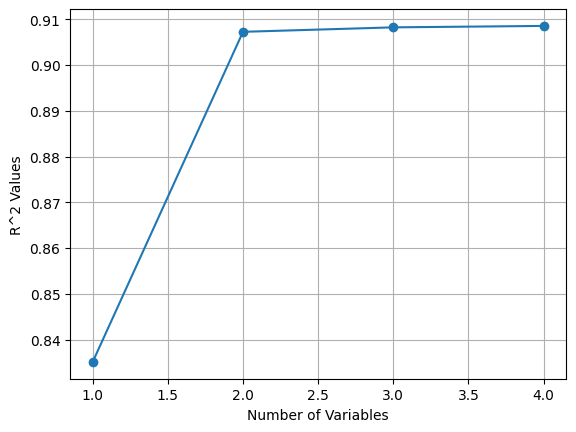

In [7]:
# Extract the third values and the lengths of tuples from the results list
r2_scores = [result[1] for result in results]
num_vars = [len(result[0]) for result in results]

# Create a scatter plot
plt.plot(num_vars, r2_scores, marker='o', label="Best Subsets")
plt.xlabel('Number of Variables')
plt.ylabel('R^2 Values')
plt.grid(True)

# Show the plot
plt.show()

The estimated model for this ideal is identical to the best subset selection case. 

In [8]:
model = fit_model(results[1][0]) 
print(model.params)

const    0.818964
X3       2.612396
X1       0.763527
dtype: float64
